In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
CUDA = torch.cuda.is_available()

In [6]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [7]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [8]:
# hyperparameters
N = 5
k = 2
tau = 1.

In [9]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    v = Variable(torch.log(-torch.log(U + eps) + eps))
    if CUDA:
        v = v.cuda()
    return -v

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = self.relu(self.fc2(h1))
        return l

In [11]:
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

In [12]:
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

In [13]:
class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        
    def forward(self, x):
        return F.sigmoid(self.fc1(x))

In [14]:
def prob(outputs):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

# def signal(outputs):
#     outputs = [sample(out).narrow(1,0,1) for out in outputs]
#     return torch.cat(outputs, dim=1)

In [15]:
class RecDecoderHead(nn.Module):
    def __init__(self):
        super(RecDecoderHead, self).__init__()
        self.fc = nn.Linear(1, 128)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.fc(x))
    
class RecDecoderBody(nn.Module):
    def __init__(self):
        super(RecDecoderBody, self).__init__()
        self.fc = nn.Linear(129, 128) # prev state + hidden
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.fc(x))
    
class RecDecoderTail(nn.Module):  
    def __init__(self):
        super(RecDecoderTail, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 512)      
        self.fc3 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        o = h3.view(-1,784)
        return F.sigmoid(o)    

In [16]:
E = Encoder()
O0 = Output()
Os = [Output() for _ in range(N-1)]
Ts = [Tunnel() for _ in range(N-1)]
T1s = [Tunnel() for _ in range(N-1)]
Gs = [Gate() for _ in range(N-1)]
D_head = RecDecoderHead()
D_body = [RecDecoderBody() for _ in range(N-1)]
D_tail = RecDecoderTail()

In [17]:
if CUDA:
    E.cuda()
    O0.cuda()
    [e.cuda() for e in Os]
    [e.cuda() for e in Ts]
    [e.cuda() for e in T1s]
    [e.cuda() for e in Gs]
    D_head.cuda()
    [e.cuda() for e in D_body]
    D_tail.cuda()

In [18]:
import os
os.system('mkdir -p checkpoint_recdecoder')
PATH = 'checkpoint_recdecoder/hd_vae'
def save_model():
    torch.save(E.state_dict(), "{}_E".format(PATH))
    torch.save(O0.state_dict(), "{}_O0".format(PATH))
    
    def save_list(models, name):
        for i in range(len(models)):
            torch.save(models[i].state_dict(), "{}_{}_{}".format(PATH, name, i))
    
    save_list(Os, 'Os')
    save_list(Ts, 'Ts')
    save_list(T1s, 'T1s')
    save_list(Gs, 'Gs')
    
    torch.save(D_head.state_dict(), "{}_D_head".format(PATH))
    save_list(D_body, 'D_body')
    torch.save(D_tail.state_dict(), "{}_D_tail".format(PATH))
    
#save_model()

In [19]:
from itertools import product
    
log_two_pow_n = Variable(torch.Tensor([2**N]).log(), requires_grad=False)
if CUDA:
    log_two_pow_n = log_two_pow_n.cuda()

def get_dependent_prior_loss(x):
    acc = Variable(torch.zeros(2**N))
    if CUDA:
        acc = acc.cuda()
    acc_i = 0
    for _path in product(range(2), repeat=N):
        path = Variable(torch.Tensor(_path), requires_grad=False)
        if CUDA:
            path = path.cuda()
        sofar = E(x)
        outputs = [O0(sofar)]
        decoder_hidden = D_head(path[0])

        for n in range(len(Ts)-1):
            sofar = Ts[n](sofar)*Gs[n](decoder_hidden) # Kind of doing "teacher forcing"
            outputs.append(Os[n](sofar))
            decoder_hidden_inp = torch.cat([decoder_hidden, path[n]], -1)
            decoder_hidden = D_body[n](decoder_hidden_inp)
        
        sofar = Ts[-1](sofar)*Gs[-1](decoder_hidden) # Kind of doing "teacher forcing"
        outputs.append(Os[-1](sofar))
        
        q = prob(outputs)

        _idx = path.data
        select_mat = Variable(torch.stack([1-_idx, _idx]).t(), requires_grad=False)
        if CUDA:
            select_mat = select_mat.cuda()
        select_mat = select_mat.expand(torch.Size([x.shape[0]]) + select_mat.shape)
        probs = q.mul(select_mat).sum(-1) # shape (batch x N)
        log_q = (probs+1e-20).log().sum(-1) # shape (batch)
        kl_term = log_q.exp().mul(log_two_pow_n + log_q) # shape (batch)
        kl_term = kl_term.mean() # shape (1) - take sum over minibatch

        acc[acc_i] = kl_term
        acc_i += 1

    return acc.sum()

In [20]:
# TESTING
# Hacky! Getting a data point.
for batch_idx, (data, _) in enumerate(train_loader):
    data = Variable(data)
    if CUDA:
        data = data.cuda()
    x = data.view(-1,784)
    x = x[0:4]
    break
    
get_dependent_prior_loss(x)

Variable containing:
1.00000e-03 *
  2.3605
[torch.FloatTensor of size 1]

In [21]:
x

Variable containing:
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 4x784]

In [22]:
# TODO
# objective
def loss_function(recon_x, x, q):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)/bsize # TODO eddie: changed from size_average=False
    # Assuming independent latent
    KLD = torch.sum(q*(torch.log(q+1E-20)-np.log(1/k)))/bsize

    # Assuming dependent latent
#     KLD = get_dependent_prior_loss(x)
    return BCE, KLD

In [23]:
params = [
    {'params':E.parameters()},
    {'params':O0.parameters()} 
] + [{'params':o.parameters()} for o in Os] \
  + [{'params':t.parameters()} for t in Ts] \
  + [{'params': g.parameters()} for g in Gs] \
  + [{'params': D_head.parameters()}, {'params': D_tail.parameters()}] \
  + [{'params': d_body.parameters()} for d_body in D_body]
optimizer = optim.Adam(params, lr=1e-4)

In [24]:
best_loss_sofar = 9999

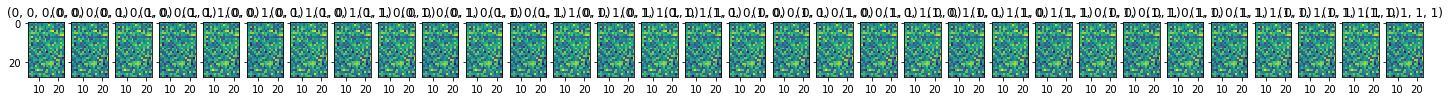

In [25]:
from itertools import product

def debug():
    f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
    kk = 0

    def make_variable(value):
        t = torch.Tensor([value]).type(torch.FloatTensor)
        t = t.unsqueeze(0)
        v = Variable(t)
        if CUDA:
            v = v.cuda()
        return v

    for path in product(range(2), repeat=N):
        decoder_hidden = D_head(make_variable(path[0]))
        for n in range(1, len(path)):
            decoder_hidden_inp = torch.cat([decoder_hidden, make_variable(path[n])], -1)
            decoder_hidden = D_body[n-1](decoder_hidden_inp)
        w = D_tail(decoder_hidden)

        ax = axes[kk]
        ax.set_title(path)
        ax.imshow(w.view(28,28).cpu().data.numpy())
        kk += 1
    plt.show()
    
debug()

In [26]:
def train(epoch):
    global best_loss_sofar
    train_bce_loss = 0
    train_kld_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        x = data.view(-1,784)
        optimizer.zero_grad()
#         sofar = E(x)
        compressed = E(x)
#         outputs = [O0(sofar)]
        outputs = [O0(compressed)]
        samples = [sample(outputs[-1])]
        decoder_hidden = D_head(samples[-1])
        # TODO unroll this may make it faster
        for n in range(len(Ts)):
            sofar = compressed
            sofar = Ts[n](sofar)*Gs[n](decoder_hidden)
            outputs.append(Os[n](sofar))
            samples.append(sample(outputs[-1]))
            
            decoder_hidden_inp = torch.cat([decoder_hidden, samples[-1]], -1)
            decoder_hidden = D_body[n](decoder_hidden_inp)
            
        recon_x = D_tail(decoder_hidden)
     
        bits = torch.cat(samples, dim=1) # for debugging only
        q = prob(outputs)

        BCE, KLD = loss_function(recon_x, x, q)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        
        train_bce_loss += BCE.data[0]
        train_kld_loss += KLD.data[0]
        
#         if batch_idx % 200 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE loss: {:.6f}\tKLD loss: {:.6f}'.format(
#                 epoch+1, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 BCE.data[0] / len(data),
#                 KLD.data[0] / len(data)))
            
    avg_bce_loss = train_bce_loss / len(train_loader.dataset)
    avg_kld_loss = train_kld_loss / len(train_loader.dataset)
    avg_loss = avg_bce_loss + avg_kld_loss
    print('====> Epoch: {} Average BCE loss: {:.4f}, Average KLD loss: {:.4f}, Total: {:.4f}'.format(
          epoch+1, avg_bce_loss, avg_kld_loss, avg_loss))
    
    if avg_loss < best_loss_sofar:
        print("Loss {} is better than previous best {}, saving model".format(avg_loss, best_loss_sofar))
        save_model()
        best_loss_sofar = avg_loss
        debug()
        
    return q, bits # debugging

====> Epoch: 1 Average BCE loss: 2.4233, Average KLD loss: 0.0067, Total: 2.4299
Loss 2.429934542933654 is better than previous best 9999, saving model


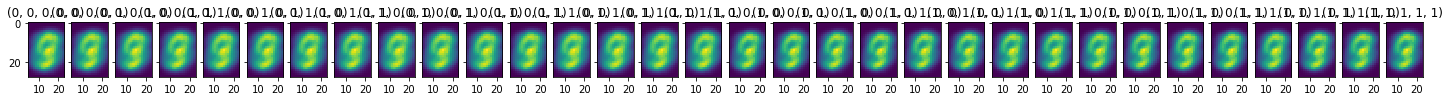

====> Epoch: 2 Average BCE loss: 2.0629, Average KLD loss: 0.0069, Total: 2.0698
Loss 2.06978251529634 is better than previous best 2.429934542933654, saving model


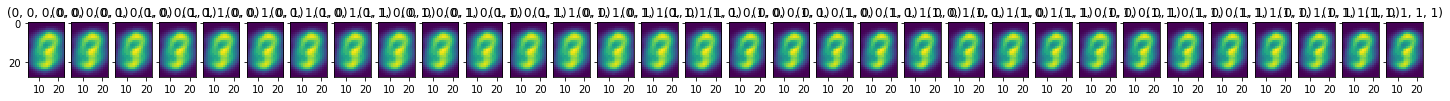

====> Epoch: 3 Average BCE loss: 2.0466, Average KLD loss: 0.0046, Total: 2.0513
Loss 2.051280296018968 is better than previous best 2.06978251529634, saving model


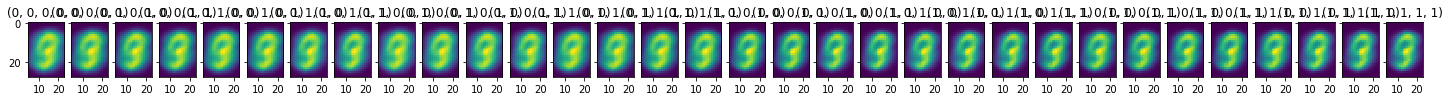

====> Epoch: 4 Average BCE loss: 2.0078, Average KLD loss: 0.0102, Total: 2.0181
Loss 2.018054841860135 is better than previous best 2.051280296018968, saving model


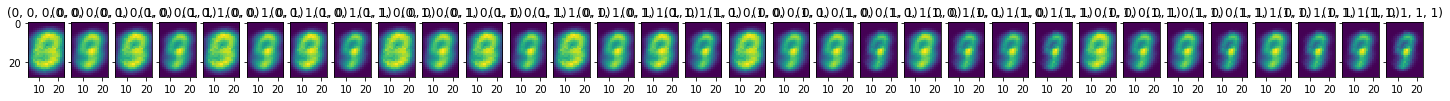

====> Epoch: 5 Average BCE loss: 1.9304, Average KLD loss: 0.0119, Total: 1.9423
Loss 1.9422602776646614 is better than previous best 2.018054841860135, saving model


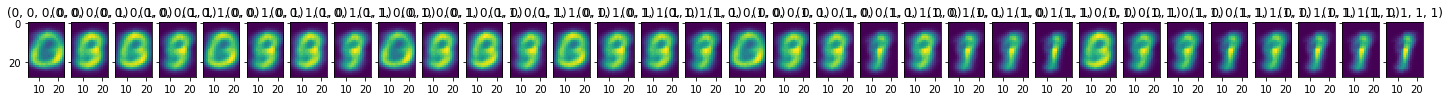

====> Epoch: 6 Average BCE loss: 1.9122, Average KLD loss: 0.0135, Total: 1.9257
Loss 1.9257014903863272 is better than previous best 1.9422602776646614, saving model


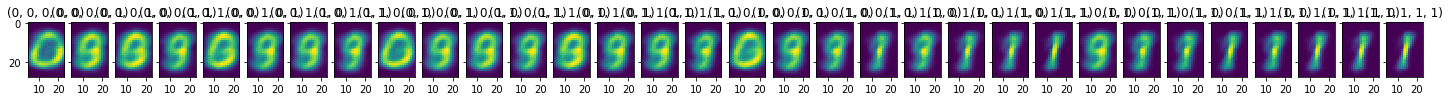

====> Epoch: 7 Average BCE loss: 1.9023, Average KLD loss: 0.0151, Total: 1.9174
Loss 1.9173536808133125 is better than previous best 1.9257014903863272, saving model


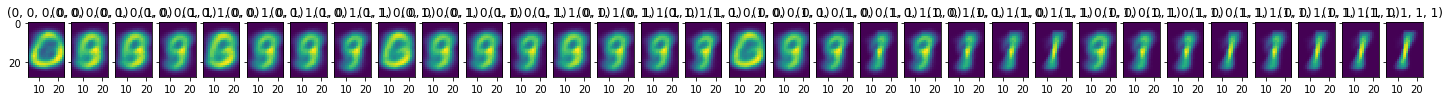

====> Epoch: 8 Average BCE loss: 1.8854, Average KLD loss: 0.0165, Total: 1.9019
Loss 1.9019156839589277 is better than previous best 1.9173536808133125, saving model


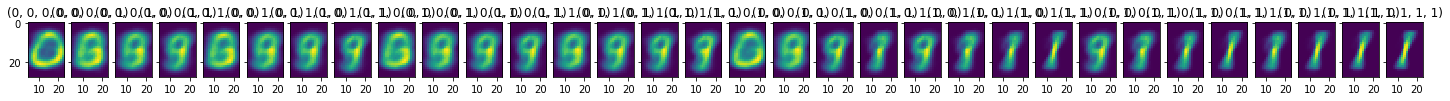

====> Epoch: 9 Average BCE loss: 1.8622, Average KLD loss: 0.0173, Total: 1.8795
Loss 1.8794795959631603 is better than previous best 1.9019156839589277, saving model


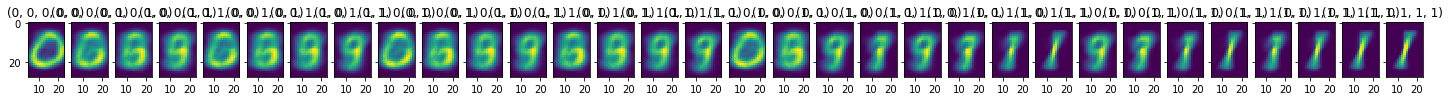

====> Epoch: 10 Average BCE loss: 1.8516, Average KLD loss: 0.0179, Total: 1.8695
Loss 1.8695059623380503 is better than previous best 1.8794795959631603, saving model


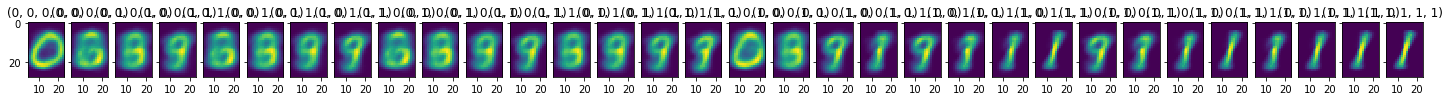

CPU times: user 15min 32s, sys: 13.5 s, total: 15min 46s
Wall time: 5min 31s


In [27]:
%%time
for epoch in range(10):
    q, bits = train(epoch)

====> Epoch: 1 Average BCE loss: 1.8447, Average KLD loss: 0.0185, Total: 1.8632
Loss 1.8632132175266742 is better than previous best 1.8695059623380503, saving model


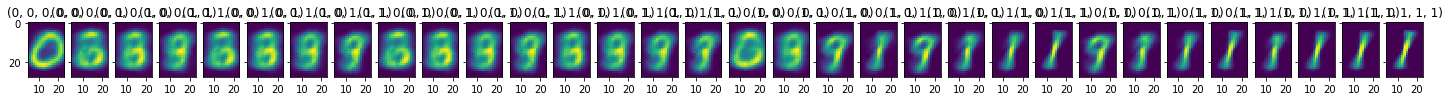

====> Epoch: 2 Average BCE loss: 1.8389, Average KLD loss: 0.0212, Total: 1.8602
Loss 1.8601579746524493 is better than previous best 1.8632132175266742, saving model


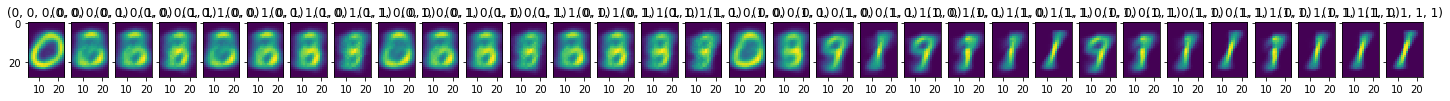

====> Epoch: 3 Average BCE loss: 1.8298, Average KLD loss: 0.0205, Total: 1.8503
Loss 1.8503207412481308 is better than previous best 1.8601579746524493, saving model


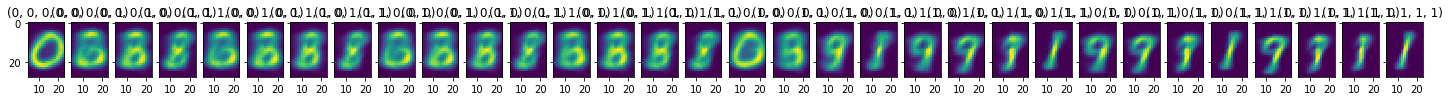

====> Epoch: 4 Average BCE loss: 1.8101, Average KLD loss: 0.0210, Total: 1.8311
Loss 1.8311226030468941 is better than previous best 1.8503207412481308, saving model


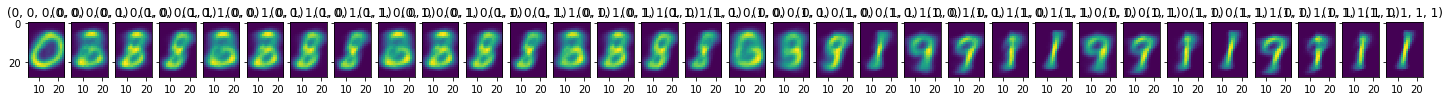

====> Epoch: 5 Average BCE loss: 1.8014, Average KLD loss: 0.0208, Total: 1.8222
Loss 1.8221898730158805 is better than previous best 1.8311226030468941, saving model


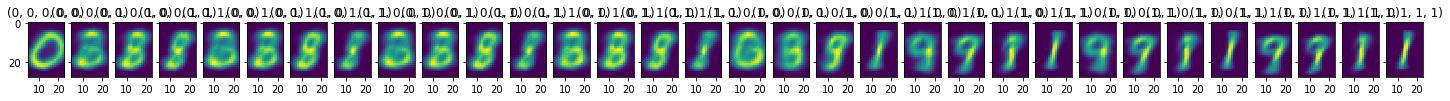

====> Epoch: 6 Average BCE loss: 1.7973, Average KLD loss: 0.0208, Total: 1.8181
Loss 1.818064595514536 is better than previous best 1.8221898730158805, saving model


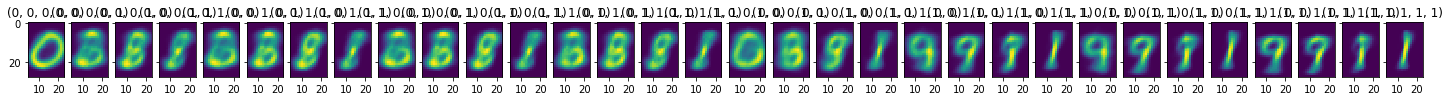

====> Epoch: 7 Average BCE loss: 1.7917, Average KLD loss: 0.0209, Total: 1.8127
Loss 1.8126951450486979 is better than previous best 1.818064595514536, saving model


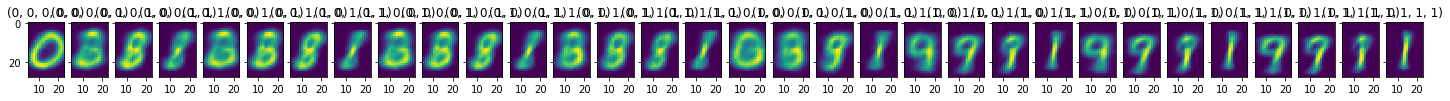

====> Epoch: 8 Average BCE loss: 1.7880, Average KLD loss: 0.0208, Total: 1.8089
Loss 1.8088918707231683 is better than previous best 1.8126951450486979, saving model


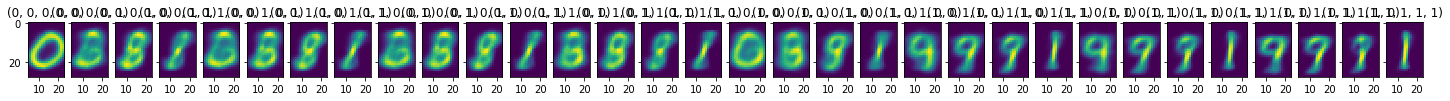

====> Epoch: 9 Average BCE loss: 1.7857, Average KLD loss: 0.0212, Total: 1.8069
Loss 1.8069047060290973 is better than previous best 1.8088918707231683, saving model


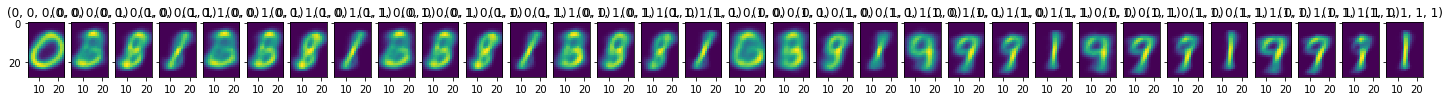

====> Epoch: 10 Average BCE loss: 1.7872, Average KLD loss: 0.0213, Total: 1.8086
CPU times: user 16min 30s, sys: 14.8 s, total: 16min 45s
Wall time: 5min 50s


In [28]:
%%time
for epoch in range(10):
    q, bits = train(epoch)

In [29]:
%%time
for epoch in range(10):
    q, bits = train(epoch)

====> Epoch: 1 Average BCE loss: 1.7854, Average KLD loss: 0.0219, Total: 1.8073
====> Epoch: 2 Average BCE loss: 1.7872, Average KLD loss: 0.0221, Total: 1.8092
====> Epoch: 3 Average BCE loss: 1.7864, Average KLD loss: 0.0223, Total: 1.8087
====> Epoch: 4 Average BCE loss: 1.7882, Average KLD loss: 0.0225, Total: 1.8107
====> Epoch: 5 Average BCE loss: 1.7900, Average KLD loss: 0.0224, Total: 1.8124
====> Epoch: 6 Average BCE loss: 1.7903, Average KLD loss: 0.0226, Total: 1.8129


KeyboardInterrupt: 

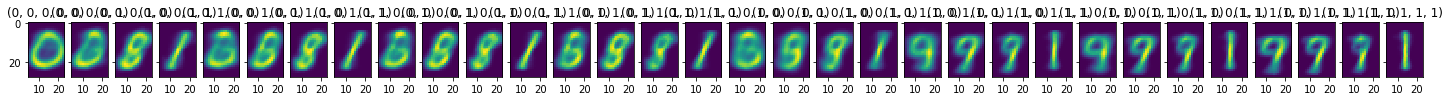

In [30]:
debug()